### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda
Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))

mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))


# attack = "fully"
# mnist_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_mnist_model.pth"))
# cifar_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_cifar_model.pth"))
# svhn_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
# Loading Data
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

### Projected Gradient Descent
Projected Gradient Descent is an optimization algorithm that iteratively computes the gradient of the loss and perturbs the image in the direction of the loss gradient. This algorithm has unique hyperparameters. We have a value $α$ which controls the step size the image moves along the gradient, but we also have something known as the $ϵ$-ball. Around the image in the vector space exists a multi dimensional threshold where the image is still percievable to humans. We clip the perturbed output image such that it always exists within this epsilon ball, and we can expand or shrink the epsilon to tune results.

\begin{array}{l}
\textbf{while } t < \text{ iterations:} \\
\hspace{2em} x_{t+1} = Clip(x_t + \alpha \cdot sign(\nabla_x J(\theta, x_t, y)), x, x + \epsilon)
\end{array}

PGD uses uses $L^∞$ Norm Perturbations and MUST be used against  classifiers.

In [6]:
def test_pgd(model, test_loader, epsilon, alpha):
    correct = 0
    total = 0

    adv_examples = []
    batch = 0
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch += 1
        print(f"Batch: {batch}, Epsilon: {epsilon}, Correct: {correct}")
        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)
            image.requires_grad = True
            output, _ = model(image)

            _, init_pred = torch.max(output.data, 1)

            if not torch.equal(init_pred, label):
                total +=1 
                continue
            
            

            output_final, perturbed_data = pgd_attack(image, model, init_pred, epsilon, alpha)
            _, final_pred = torch.max(output_final.data, 1)
            if torch.equal(final_pred, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            print(f"{correct}/{total}")
            total +=1 
            # break
        # break

    accuracy = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {accuracy}")
    return accuracy, adv_examples

In [7]:
# MNIST
accuracy, examples = test_pgd(mnist_resnet_model, test_loader_mnist, .25, 1 )
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/1
0/2
0/3
0/4
0/5
0/6
0/7
0/8
0/9
0/10
0/11
0/12
0/13
0/14
0/15
0/16
0/17
0/18
0/19
0/20
0/21
0/22
0/23
0/24
0/25
0/26
0/27
0/28
0/29
1/30
1/31
1/32
1/33
1/34
1/35
1/36
1/37
1/38
1/39
1/40
1/41
1/42
1/43
1/44
1/45
1/46
1/47
1/48
1/49
1/50
1/51
1/52
1/53
1/54
1/55
1/56
1/57
1/58
1/59
1/60
2/61
2/62
2/63
2/64
2/65
2/66
2/67
2/68
2/69
2/70
2/71
2/72
2/73
2/74
2/75
2/76
2/77
2/78
2/79
2/80
2/81
3/82
3/83
3/84
3/85
3/86
3/87
3/88
3/89
4/90
4/91
4/92
4/93
4/94
4/95
4/96
4/97
4/98
4/99
4/100
4/101
4/102
4/103
4/104
4/105
4/106
4/107
4/108
4/109
5/110
5/111
5/112
5/113
5/114
5/115
5/116
5/117
5/118
5/119
5/120
5/121
5/122
5/123
5/124
5/125
5/126
5/127
5/128
5/129
5/130
5/131
5/132
5/133
6/134
6/135
6/136
6/137
6/138
6/139
6/140
6/141
6/142
6/143
6/144
6/145
7/146
7/147
7/148
7/149
7/150
7/151
7/152
7/153
7/154
7/155
7/156
7/157
7/158
7/159
7/160
7/161
7/162
7/163
7/164
7/165
7/166
7/167
7/168
7/169
7/170
7/171
7/172
7/173
7/174
7/175
7/176
8/177
8/178


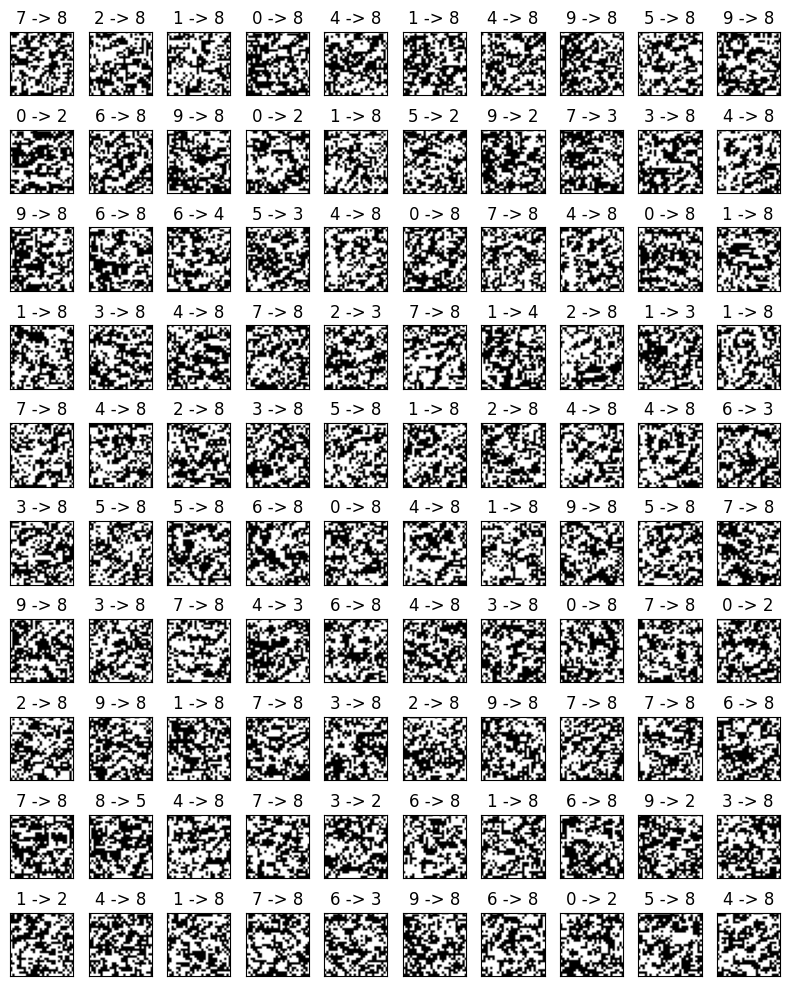

In [8]:
# MNIST Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
# CIFAR10
accuracy, examples = test_pgd(cifar_resnet_model, test_loader_cifar10, .25, 0.00625)
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/1
0/3
0/5
0/6
0/7
0/9
0/10
0/11
0/13
0/14
0/15
0/16
0/17
0/18
0/19
0/21
0/23
0/25
0/26
0/27
0/28
0/29
0/30
0/32
0/33
0/34
0/37
1/38
1/39
1/40
2/41
2/43
2/44
2/45
2/46
2/48
2/49
2/50
2/51
2/53
2/54
2/55
2/56
2/60
2/62
2/63
2/64
2/65
2/66
2/67
2/70
2/71
3/72
3/73
3/74
4/75
4/77
4/78
4/79
4/80
5/82
5/83
5/84
5/86
5/88
5/89
5/90
6/92
6/93
6/94
6/95
6/96
6/97
7/98
7/99
7/100
7/101
7/102
7/104
7/105
7/107
7/108
7/109
7/110
7/111
7/113
7/115
7/116
7/117
7/120
7/121
7/122
7/123
7/124
7/126
7/127
7/130
7/131
7/132
8/133
8/134
8/135
8/136
8/137
8/138
8/140
8/141
8/142
8/143
8/144
8/145
8/146
8/149
8/150
8/151
8/152
8/153
8/154
8/155
8/156
8/157
8/159
8/161
8/162
8/163
8/165
8/166
8/167
8/170
8/171
8/173
8/174
8/175
8/176
8/177
8/179
8/180
8/181
8/182
8/183
8/184
8/185
8/186
8/191
8/192
8/193
8/194
8/196
8/197
8/198
8/199
8/200
8/201
8/202
8/203
8/204
8/205
8/206
8/207
8/208
8/209
8/212
8/214
8/215
8/216
8/217
8/219
8/220
9/222
9/223
9/225
9/227
9/231
9/2

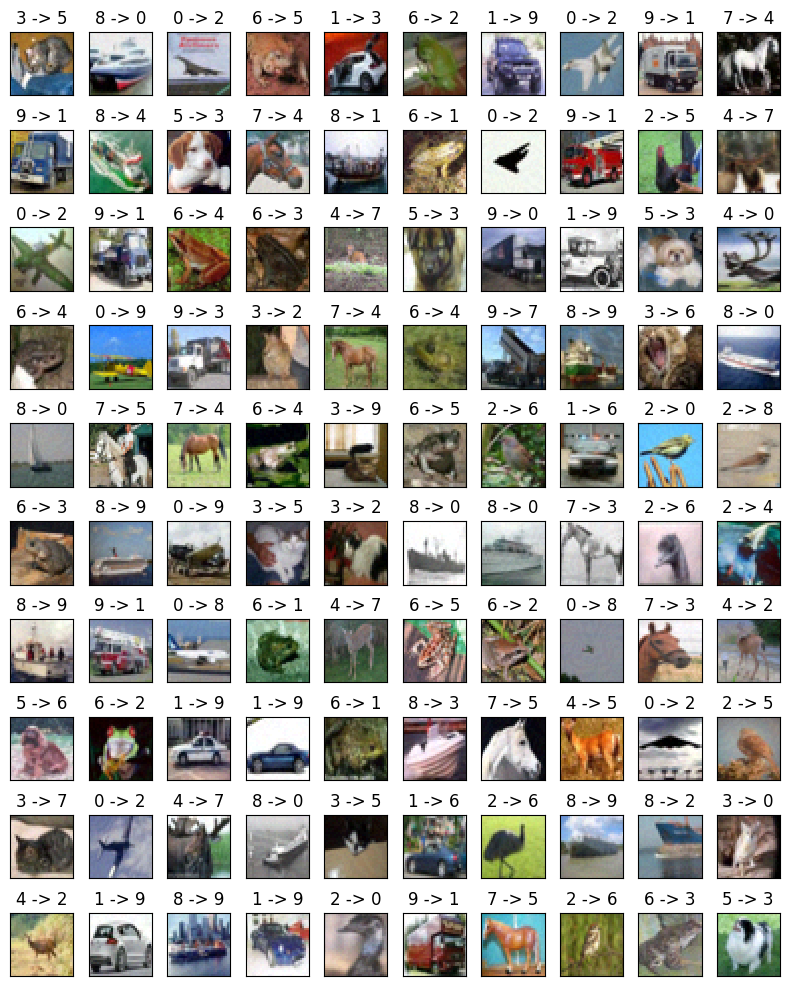

In [10]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [11]:
# SVHN
accuracy, examples = test_pgd(svhn_resnet_model, test_loader_svhn, .25, 0.00625)
print(accuracy)

Batch: 1, Epsilon: 0.25, Correct: 0
0/0
0/1
0/2
0/3
0/4
0/5
0/6
0/7
0/8
0/9
0/10
0/11
0/12
0/13
0/14
0/15
0/16
0/17
1/18
2/19
3/20
4/21
4/22
5/24
5/25
5/26
5/27
5/28
5/29
6/31
6/32
6/33
6/34
6/35
6/36
7/37
7/38
7/39
7/41
7/42
7/43
7/44
7/45
7/46
8/47
8/48
8/49
8/50
9/51
10/52
10/53
10/54
10/57
10/60
10/61
10/62
10/63
10/64
10/65
10/66
10/67
10/68
10/69
10/70
10/71
10/72
10/73
10/74
10/75
10/76
10/77
10/78
10/79
10/80
10/81
10/82
10/83
10/84
10/85
10/86
10/87
10/88
10/89
10/90
10/91
10/92
10/93
10/94
10/95
10/97
10/98
10/99
10/100
10/101
11/102
11/103
11/104
12/105
13/106
13/107
13/108
13/109
14/110
15/111
15/112
15/114
15/115
16/116
16/117
16/118
16/119
16/120
16/121
16/122
17/123
17/124
17/125
17/126
17/127
17/128
17/129
18/130
18/132
18/133
18/134
18/135
18/136
18/137
18/138
18/139
19/141
19/142
19/143
20/144
21/145
22/146
22/147
22/148
23/149
23/150
23/151
23/152
23/153
23/154
23/155
23/157
23/158
23/159
24/160
24/161
24/162
25/163
25/164
25/165
25/166
25/167
25/168
25/169
25/170
25

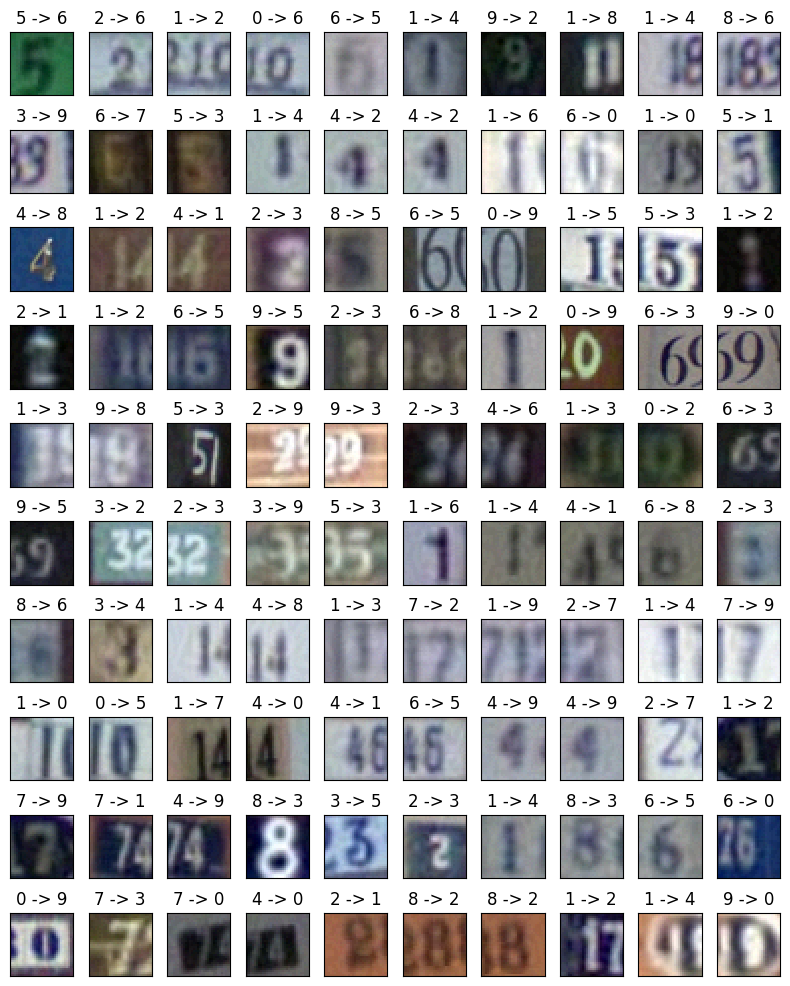

In [12]:
# CIFAR10/SVHN Viewer
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255.0  # Normalizing pixel values
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()